# Kalman Filter Example

Kalman filters can be used to infer the hidden state of a system (for which the system dynamics are known) from noisy measurements (if the conditional measurement distribution is known). This type of model and inference can be used to track the evolution of any type of system where the next state is only dependent on the previous state (and where the previously mentioned requirements are met). A typical example of the application of Kalman filters is in radar tracking of objects, where the measurements can be quite noisy and it is disabled to get more accurate estimates of the position of the tracked objects. In this notebook, we will look at a simple example
of a Kalman filter with linear Gaussian conditional distributions. There are however extensions to the standard Kalman filter that allow for non-linear transformations.

In [1]:
import sys
sys.path.append('../../')
import numpy as np
from veroku.factors.gaussian import Gaussian, GaussianMixture
from veroku.cluster_graph import ClusterGraph
from veroku.factors.gaussian import make_linear_gaussian_cpd_template
import copy

import ipywidgets as widgets
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import Ellipse

### Plotting Helper Functions
Below are some helper functions that we will use for plotting the results.

In [2]:
def get_kalman_filter_position_posteriors(kf_cg, num_timesteps, pos_dim, X_var_templates):
    # Note: here we assume that the position variables start at 0
    single_space_var_names = None
    marginals = []
    means = []
    for i in range(num_timesteps-1):
        X_var_format_dict = {'t_now':i}
        X_vars = [vt.format(**X_var_format_dict) for vt in X_var_templates]

        X_pos_vars = X_vars[0:pos_dim]
        if single_space_var_names is None:
            single_space_var_names = X_pos_vars
        
        pos_marginal = kf_cg.get_marginal(X_pos_vars)     
        pos_mean = pos_marginal.get_mean()
        means.append(pos_mean)
        marginals.append(pos_marginal)
    return marginals

def get_ellipse_patch(cov, mean, std_devs=2):
    eigen_values_array, eigen_vectors_array = np.linalg.eig(cov)
    max_len_eig_vector = eigen_vectors_array[:, np.argmax(eigen_values_array)]
    angle = np.arctan2(max_len_eig_vector[1],max_len_eig_vector[0])
    std_dev_primary_comp  = np.sqrt(eigen_values_array[0])
    std_dev_secondary_comp  = np.sqrt(eigen_values_array[1])

    ellipse = matplotlib.patches.Ellipse(mean,
                                         std_dev_primary_comp*std_devs,
                                         std_dev_secondary_comp*std_devs,
                                         angle=angle,
                                         fc=(1,0,0,0),
                                         ec = (0,0,1,1),
                                         lw=2)
    return ellipse

def add_ellipse(ax, ellipse):
    ax.add_patch(ellipse)


def get_2d_std_dev_ellipses(gaussians):
    ellipse_patches = []
    for g in gaussians:
        ellipse_patch = get_ellipse_patch(g.get_cov(), g.get_mean())
        ellipse_patches.append(ellipse_patch)
    return ellipse_patches

def plot_2d_std_dev_ellipses(gaussians):
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    patches = get_2d_std_dev_ellipses(gaussians)
    for patch in patches:
        ax.add_patch(patch)
    ax.autoscale()

### Template Specification
In a typical Kalman filter Bayes network, all of the conditional state distributions are identical (except for the variable names) and all of the conditional measurement distributions are also identical (except for the variable names). It, therefore, makes sense to specify factor templates for the corresponding factors to allow us to easily generate new factors with different variable names. This also allows us to create arbitrarily long graphs, which will allow us to perform inference over an arbitrary number of timesteps (each measurement corresponds to the measured state of the system at a specific timestep). Below we specify the template parameters for a linear Gaussian template.

In [3]:
# speficify 4 dimensional (2d position + 2d velocity) templates
X_now_var_templates = ['Xsx_{t_now}','Xsy_{t_now}','Xvx_{t_now}','Xvy_{t_now}']
X_nxt_var_templates = ['Xsx_{t_nxt}','Xsy_{t_nxt}','Xvx_{t_nxt}','Xvy_{t_nxt}']
Y_now_var_templates = ['Ysx_{t_now}','Ysy_{t_now}','Yvx_{t_now}','Yvy_{t_now}']

X_dim = len(X_now_var_templates)

dt = 10.1
A_X_now_X_nxt = np.array([[1, 0, dt, 0],
                          [0, 1, 0,  dt],
                          [0, 0, 1,  0],
                          [0, 0, 0,  1]])
A_X_now_Y_now = np.array([[1, 0, 0, 0],
                          [0, 1, 0, 0],
                          [0, 0, 1, 0],
                          [0, 0, 0, 1]])
N_Y = np.array([[3, 0, 0, 0],
                [0, 3, 0, 0],
                [0, 0, 2, 0],
                [0, 0, 0, 2]])*5000.0
N_X = np.array([[0.1, 0, 0, 0],
                [0, 0.1, 0, 0],
                [0, 0, 0.2, 0],
                [0, 0, 0, 0.2]])*50
X_now_X_nxt_template = make_linear_gaussian_cpd_template(A_X_now_X_nxt,
                                                         N_X,
                                                         X_now_var_templates,
                                                         X_nxt_var_templates)
X_now_Y_now_template = make_linear_gaussian_cpd_template(A_X_now_Y_now,
                                                         N_Y,
                                                         X_now_var_templates,
                                                         Y_now_var_templates)

### Factor and Data Generation
In this section, we generate the factors (from the above templates) which will be used to construct the cluster graph that we will use for inference. We also generate data for the ground truth system state (the actual position of the target over time) as well as noisy measurements of this state.

In [4]:
X_prior_var_format_dict = {'t_now':0}
X_prior_vars = [vt.format(**X_prior_var_format_dict) for vt in X_now_var_templates]

X_prior = Gaussian(cov=np.eye(X_dim)*100, mean=np.zeros([X_dim, 1]), log_weight=0.0, var_names=X_prior_vars)
X_prior.mean[2,0] = 5
factors = [X_prior]

# data generation

dummy_var_names = [str(i) for i in range(X_dim)]
measurement_noise_distribution = Gaussian(mean=np.zeros([X_dim, 1]), cov=N_Y, log_weight=0,var_names=dummy_var_names)
process_noise_distribution = Gaussian(mean=np.zeros([X_dim, 1]), cov=N_X, log_weight=0,var_names=dummy_var_names)
system_state = X_prior.sample(1)


num_time_steps = 15
evidence_dict = {}

back_transed_measurements_over_time = []
system_states_over_time = []
for timestep in range(num_time_steps):
    var_format_dict = {'t_now':timestep,'t_nxt':timestep+1}
    
    XX_factor = X_now_X_nxt_template.make_factor(var_format_dict)
    factors.append(XX_factor)
    if (timestep > 0) and (timestep < num_time_steps-1):
        XY_factor = X_now_Y_now_template.make_factor(var_format_dict)
        factors.append(XY_factor)
        Y_now_vars = [vt.format(**var_format_dict) for vt in Y_now_var_templates]
        
        Y_now_values = (system_state + measurement_noise_distribution.sample(1)).ravel().tolist()
        observations_now = {var_name:value for var_name, value in zip(Y_now_vars, Y_now_values)}
        evidence_dict.update(observations_now)
        
        # for plotting and performance evaluation
        Y_transed_to_X_now = np.array(Y_now_values)@np.linalg.inv(A_X_now_Y_now)
        system_states_over_time.append(copy.deepcopy(system_state))
        back_transed_measurements_over_time.append(Y_transed_to_X_now)
        
    
    system_state = A_X_now_X_nxt@system_state + process_noise_distribution.sample(1)


### Inference
In this section, we create the cluster graph and use it to perform inference (with synchronous message passing) to efficiently get the posterior marginals of the system state at all the time steps.

In [5]:
Kalman_filter_cg = ClusterGraph(factors=factors, special_evidence=evidence_dict, make_animation_gif=False)


cluster_special_evidence_vars =  []
cluster_special_evidence_values =  []
cluster_special_evidence_vars =  []
cluster_special_evidence_values =  []
cluster_special_evidence_vars =  ['Ysx_1', 'Ysy_1', 'Yvx_1', 'Yvy_1']
cluster_special_evidence_values =  [254.0558633666095, -273.4021501869045, -136.36283641545225, -95.59255416270004]
cluster_special_evidence_vars =  []
cluster_special_evidence_values =  []
cluster_special_evidence_vars =  ['Ysx_2', 'Ysy_2', 'Yvx_2', 'Yvy_2']
cluster_special_evidence_values =  [39.42843292007571, -126.30171431109424, -125.48786976983867, 110.40408109635541]
cluster_special_evidence_vars =  []
cluster_special_evidence_values =  []
cluster_special_evidence_vars =  ['Ysx_3', 'Ysy_3', 'Yvx_3', 'Yvy_3']
cluster_special_evidence_values =  [-42.842905983897225, -88.47016438267372, 158.6160047221428, -138.9207598297455]
cluster_special_evidence_vars =  []
cluster_special_evidence_values =  []
cluster_special_evidence_vars =  ['Ysx_4', 'Ysy_4', 'Yvx_4', 'Yvy_4']


self._special_evidence:  {}
cluster_id =  c0#Xsx_0,Xsy_0,Xvx_0,Xvy_0,Xsx_1,Xsy_1,Xvx_1,Xvy_1
self._special_evidence:  {}
cluster_id =  c1#Xsx_1,Xsy_1,Xvx_1,Xvy_1,Xsx_2,Xsy_2,Xvx_2,Xvy_2
self._special_evidence:  {}
cluster_id =  c0#Xsx_0,Xsy_0,Xvx_0,Xvy_0,Xsx_1,Xsy_1,Xvx_1,Xvy_1
self._special_evidence:  {'Ysx_1': 254.0558633666095, 'Ysy_1': -273.4021501869045, 'Yvx_1': -136.36283641545225, 'Yvy_1': -95.59255416270004}
cluster_id =  c2#Xsx_1,Xsy_1,Xvx_1,Xvy_1,Ysx_1,Ysy_1,Yvx_1,Yvy_1
self._special_evidence:  {}
cluster_id =  c1#Xsx_1,Xsy_1,Xvx_1,Xvy_1,Xsx_2,Xsy_2,Xvx_2,Xvy_2
self._special_evidence:  {}
cluster_id =  c3#Xsx_2,Xsy_2,Xvx_2,Xvy_2,Xsx_3,Xsy_3,Xvx_3,Xvy_3
self._special_evidence:  {}
cluster_id =  c1#Xsx_1,Xsy_1,Xvx_1,Xvy_1,Xsx_2,Xsy_2,Xvx_2,Xvy_2
self._special_evidence:  {'Ysx_2': 39.42843292007571, 'Ysy_2': -126.30171431109424, 'Yvx_2': -125.48786976983867, 'Yvy_2': 110.40408109635541}
cluster_id =  c4#Xsx_2,Xsy_2,Xvx_2,Xvy_2,Ysx_2,Ysy_2,Yvx_2,Yvy_2
self._special_evidence:  {}

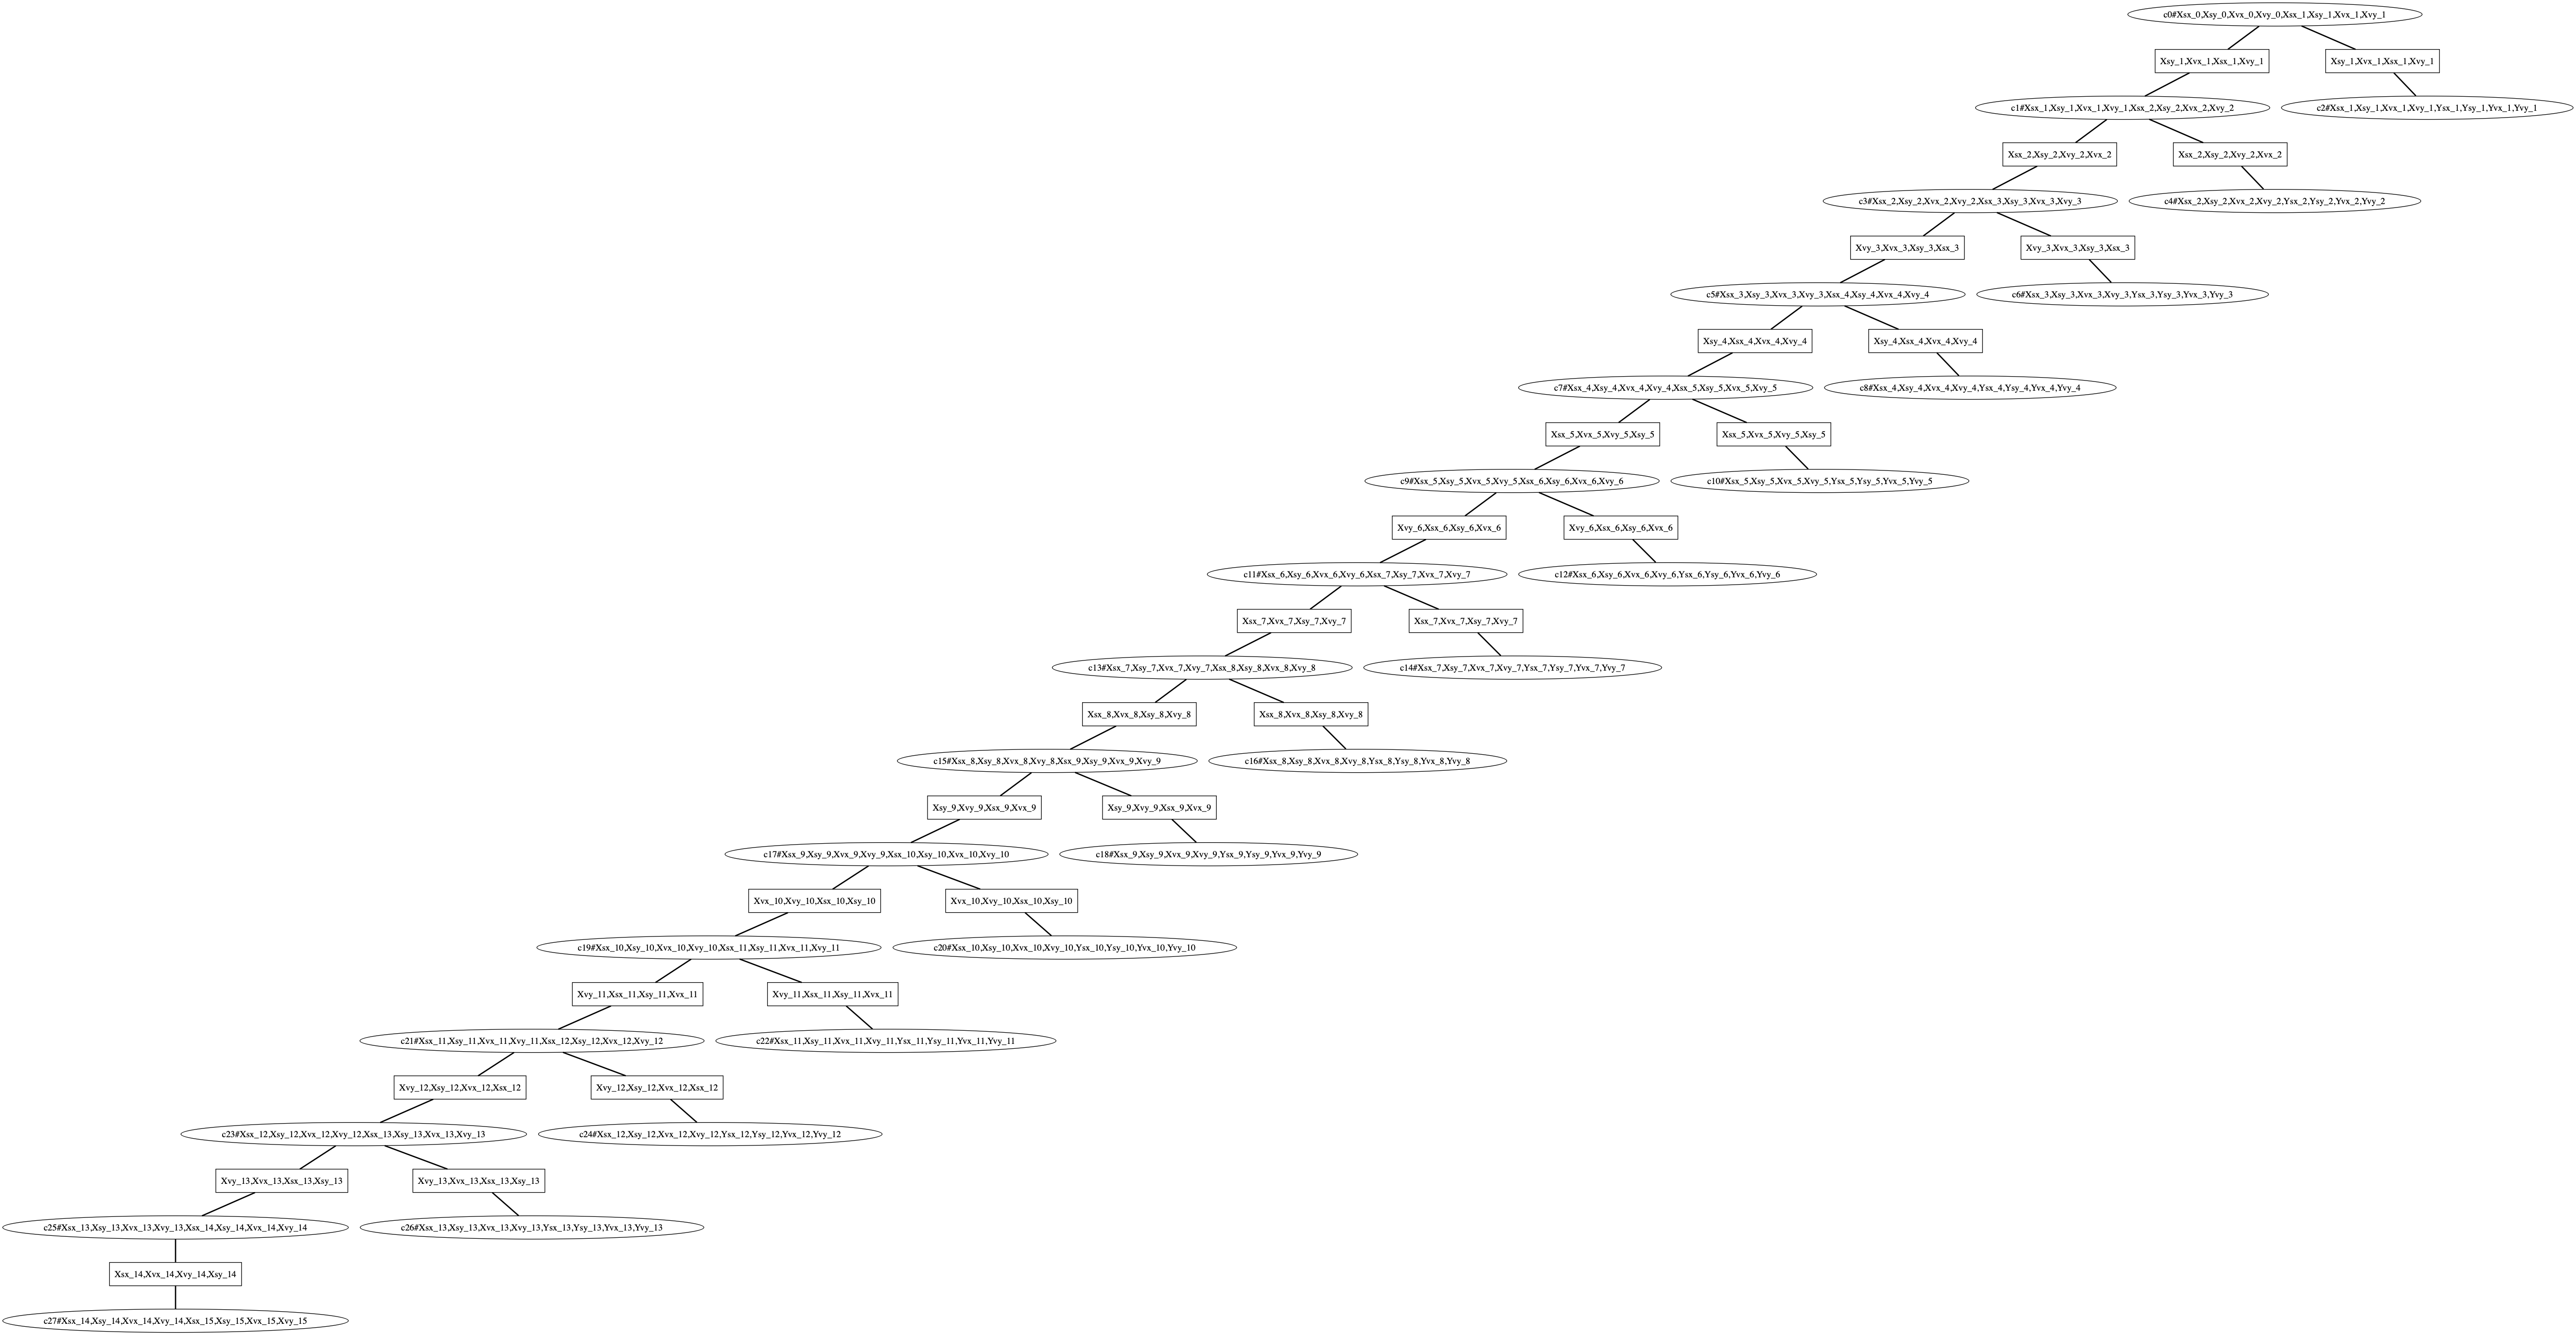

In [6]:
Kalman_filter_cg.show()

In [7]:
Kalman_filter_cg.process_graph(max_iter=1000, tol=1e-2)

[gmp.next_information_gain for gmp in graph_message_paths]: 
 [inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
self._special_evidence:  {}
cluster_id =  c1#Xsx_1,Xsy_1,Xvx_1,Xvy_1,Xsx_2,Xsy_2,Xvx_2,Xvy_2
self._special_evidence:  {}
cluster_id =  c1#Xsx_1,Xsy_1,Xvx_1,Xvy_1,Xsx_2,Xsy_2,Xvx_2,Xvy_2
self._special_evidence:  {}
cluster_id =  c1#Xsx_1,Xsy_1,Xvx_1,Xvy_1,Xsx_2,Xsy_2,Xvx_2,Xvy_2
0
self._special_evidence:  {'Ysx_1': 254.0558633666095, 'Ysy_1': -273.4021501869045, 'Yvx_1': -136.36283641545225, 'Yvy_1': -95.59255416270004}
cluster_id =  c2#Xsx_1,Xsy_1,Xvx_1,Xvy_1,Ysx_1,Ysy_1,Yvx_1,Yvy_1
1
0.0 < tol


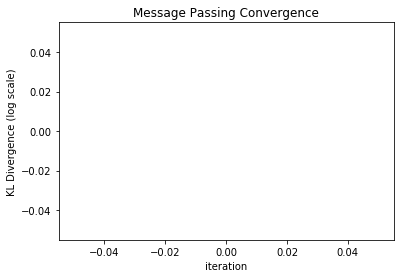

In [8]:
sync_message_passing_max_distances = Kalman_filter_cg.sync_message_passing_max_distances
non_inf_max_distances = [d for d in sync_message_passing_max_distances if d != np.inf]
plt.plot(np.log(non_inf_max_distances))
plt.title('Message Passing Convergence');
plt.xlabel('iteration');
plt.ylabel('KL Divergence (log scale)');

### Posterior Plotting
In this section we extract the posterior state marginals and prepare the measurement and true state data for plotting.

In [9]:
# Marginal extractiong and data preperation
position_posteriors = get_kalman_filter_position_posteriors(kf_cg=Kalman_filter_cg,
                                                            num_timesteps=num_time_steps,
                                                            pos_dim=2,
                                                            X_var_templates=X_now_var_templates)
X_meas_over_time = np.concatenate([np.expand_dims(X_meas_t, 0) for X_meas_t in back_transed_measurements_over_time])
X_true_over_time = np.concatenate([X_true_t.T for X_true_t in system_states_over_time])



all_xs = X_meas_over_time[:,0].tolist() + X_true_over_time[:,0].tolist()
all_ys = X_meas_over_time[:,1].tolist() + X_true_over_time[:,1].tolist()

# set up plot
 

legend_elements = [Line2D([0], [0], marker='o', color='w', label='Scatter', markerfacecolor='b', markersize=15),
                   Line2D([0], [0], marker='o', color='w', label='Scatter', markerfacecolor='r', markersize=15),
                   Line2D([0], [0], marker='o', color='w', label='Scatter', markerfacecolor='k', markersize=15)]

estimated_cov_ellipses = get_2d_std_dev_ellipses(position_posteriors)
estimated_means_array = np.concatenate([p.get_mean().T for p in position_posteriors])
last_timestep_index = len(estimated_cov_ellipses)-2

../../veroku/factors/gaussian.py:627: RuntimeWarning: invalid value encountered in log
  log_weight_ = self.g + 0.5 * uTKu + 0.5 * np.log(det_2_pi_cov)
/Users/everhardlouw/anaconda/envs/veroku-env/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in sqrt
/Users/everhardlouw/anaconda/envs/veroku-env/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in sqrt


In [10]:
for p in position_posteriors:
    p.show()
    print('\n')

vars =  ['Xsx_0', 'Xsy_0']
Cov = 
 [[100.   0.]
 [  0. 100.]]
mean = 
 [[1.7728e-13]
 [0.0000e+00]]
log_weight = 
 7.587777138244
is_vacuous:  False


vars =  ['Xsx_1', 'Xsy_1']
Cov = 
 [[10306.     0.]
 [    0. 10306.]]
mean = 
 [[50.5]
 [ 0. ]]
log_weight = 
 7.587777138253889
is_vacuous:  False


vars =  ['Xsx_2', 'Xsy_2']
Cov = 
 [[41934.1     0. ]
 [    0.  41934.1]]
mean = 
 [[101.]
 [  0.]]
log_weight = 
 15.175554276564885
is_vacuous:  False


vars =  ['Xsx_3', 'Xsy_3']
Cov = 
 [[  39.2157    0.    ]
 [  -0.     -104.4386]]
mean = 
 [[0.]
 [0.]]
log_weight = 
 nan
is_vacuous:  False


vars =  ['Xsx_4', 'Xsy_4']
Cov = 
 [[ -23.4604   -0.    ]
 [  -0.     -104.4386]]
mean = 
 [[0.]
 [0.]]
log_weight = 
 47.01528907759727
is_vacuous:  False


vars =  ['Xsx_5', 'Xsy_5']
Cov = 
 [[28.5714  0.    ]
 [ 0.     39.2157]]
mean = 
 [[0.]
 [0.]]
log_weight = 
 46.70719243610486
is_vacuous:  False


vars =  ['Xsx_6', 'Xsy_6']
Cov = 
 [[-23.4604  -0.    ]
 [ -0.     -23.4604]]
mean = 
 [[0.]

### Results Visualisation
Finally, we can visualise the (position marginal) posterior distributions in context of the ground truth and noisy measurements as they evolve over time. Below, we use a widget to do this.
If the widget does not display correctly, please ensure that the jupyter widgets are setup correctly (see https://ipywidgets.readthedocs.io/en/latest/user_install.html)

In [12]:
%matplotlib widget
fig, ax = plt.subplots(figsize=(6, 4))
ax.set_ylim([min(all_ys), max(all_ys)])
ax.set_xlim([min(all_xs), max(all_xs)])
ax.set_ylim([-3000, 30500])
ax.set_xlim([-1500, 1500])
ax.grid(True)


@widgets.interact(t=(0, last_timestep_index, 1))
def update(t = 0):
    """Remove old lines from plot and plot new one"""
    
    [l.remove() for l in ax.patches]
    ax.add_patch(estimated_cov_ellipses[t])
    plt.scatter(estimated_means_array[t:t+1,0], estimated_means_array[t:t+1,1], color='b')
    plt.scatter(X_meas_over_time[t,0], X_meas_over_time[t,1], color='r')
    plt.plot(X_true_over_time[:t,0], X_true_over_time[:t,1], color='k', marker='o')
    ax.legend(legend_elements, ['estimate', 'measurement', 'truth'])
    
    

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

interactive(children=(IntSlider(value=0, description='t', max=12), Output()), _dom_classes=('widget-interact',…